# setup

In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import calplot
import numpy as np
from scipy import stats #for streamgraph
import seaborn as sns

%matplotlib inline

None


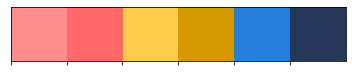

In [294]:
#set brand colours
cols = ["#ff8d8d",  "#ff6768", "#ffcd4b", "#d59a00", "#2580de", "#263859" ]
print(sns.palplot(cols))

In [2]:
# set root folder
root = os.path.abspath(os.path.join(os.getcwd(), ".."))

In [89]:
#load data
data = pd.read_csv(os.path.join(root, "data\\lisa_plastic_records_history.csv"))

# Explore

In [90]:
#create empty dataframe
df = pd.DataFrame(columns=data.columns)

In [91]:
#append number of rows from original dataframe depending on quantity
for i in range(len(data)):
    quantity = 1
    while quantity <= data["quantity"][i]:     
        df.loc[len(df.index)] = data.loc[i]
        quantity+=1

In [92]:
# clean and derive date columns
df["date"] = pd.to_datetime(pd.to_datetime(df["record_created"]).dt.date)
df["weekday"] = df["date"].dt.day_name()
df["weekday_group"] = ["weekend" if x == "Sunday" else "weekend" if x == "Saturday" else "weekday" for x in df["weekday"]]

In [136]:
#use data from 2022 for missing days in January 2021
df.loc[df["date"]== pd.to_datetime("2022-01-01"), "date"] = pd.to_datetime("2021-01-01")
df.loc[df["date"]== pd.to_datetime("2022-01-02"), "date"] = pd.to_datetime("2021-01-02")
df.loc[df["date"]== pd.to_datetime("2022-01-03"), "date"] = pd.to_datetime("2021-01-03")
df.loc[df["date"]== pd.to_datetime("2022-01-04"), "date"] = pd.to_datetime("2021-01-04")
df.loc[df["date"]== pd.to_datetime("2022-01-05"), "date"] = pd.to_datetime("2021-01-05")

#filter for only 2021 data
df = df[df["date"]< pd.to_datetime("2022-01-01")]

## Weight per day

array([<AxesSubplot:>], dtype=object)

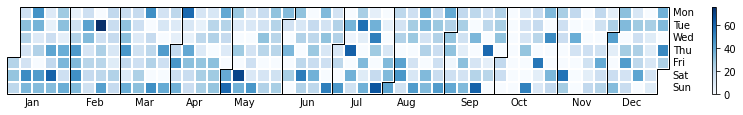

In [140]:
all_days = pd.date_range('1/1/2021', periods=365, freq='D')

events = df.groupby("date")["score"].sum()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues', yearlabels=False, edgecolor = 'black')

fig[1]

## Weight by class over time

In [142]:
pivot = df.groupby(['date', 'category_name'])['plastic_weight'].sum().unstack()
pivot = pivot.fillna(0)

#7-day rolling average
pivot = pivot.rolling( 7).mean().shift(0)

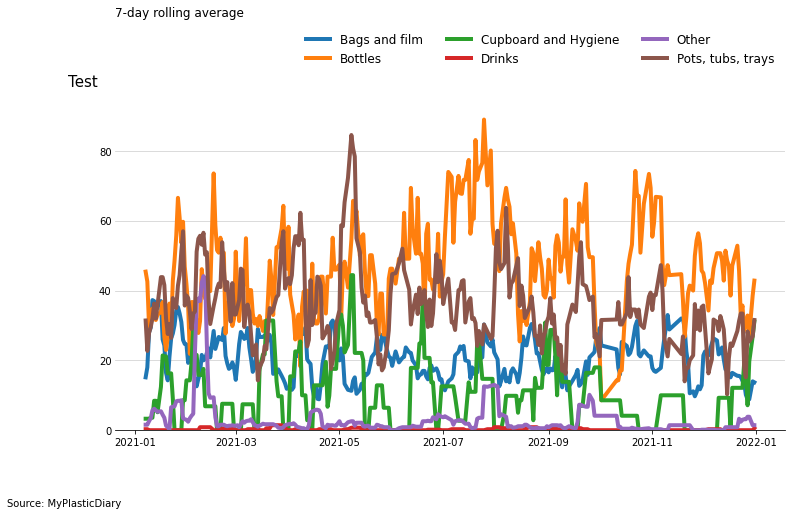

In [144]:
data = pivot

#plot

#=========
#base figure
fig, ax = plt.subplots(figsize =(12,6))

# =======
#colours
#colours = [mode_cols["car"], mode_cols["pedestrian"], mode_cols["cyclist"], ]

# =======
#lines
#remove frame
for pos in ['right', 'top',  'left']:
        plt.gca().spines[pos].set_visible(False)
        
#axis gridlines (axis='x', 'y', 'both')
plt.grid(visible=True, axis='y', zorder=1, color = "#D3D3D3")

# =======
#title and subtitle
plt.suptitle("Test", 
        size=15, y=0.95, ha='left', x=0.07, fontweight='normal')

plt.title("7-day rolling average", 
        size=12, y=1.25, ha='left', x=0, fontweight='normal')

#footer
plt.figtext(0,-0.05, "Source: MyPlasticDiary", fontsize=10, ha='left')


# =======
#plot data
i=0
for column in data.columns[:]:
    ax.plot(data.index, data[column], linewidth = 4, label=column, zorder=2)
    i+=1

# =======
#y-axis
plt.tick_params(axis='y', length = 0, color = "#444444")
ax.set_ylim(ymin=0)
ystart, yend = plt.ylim() #get y axis start and end
ax.ticklabel_format(style='plain', axis='y')

#x-axis
xstart, xend = plt.xlim()

# =======
#legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1, 1.25), fontsize=12, ncol=3)
    
plt.show()

## Proportion streamgraph - total weight

In [227]:
pivot = df.groupby(['date', 'category_name'])['plastic_weight'].sum().unstack()

#get day of year
pivot = pivot.reset_index()
pivot["doy"] = pivot["date"].dt.dayofyear

# create empty dataframe with all day of year
pivot2 = pd.DataFrame(index=np.arange(1,366)).reset_index()

#merge both
pivot = pd.merge(pivot2, pivot, left_on='index', right_on='doy', how='left')

#remove columns
pivot = pivot.drop(columns=["doy", "date"]).rename(columns={"index": "day"})

#set index
pivot = pivot.set_index(["day"])

#7-day rolling average
pivot = pivot.fillna(0)
pivot = pivot.rolling( 7).mean().shift(0)
pivot = pivot.fillna(0)

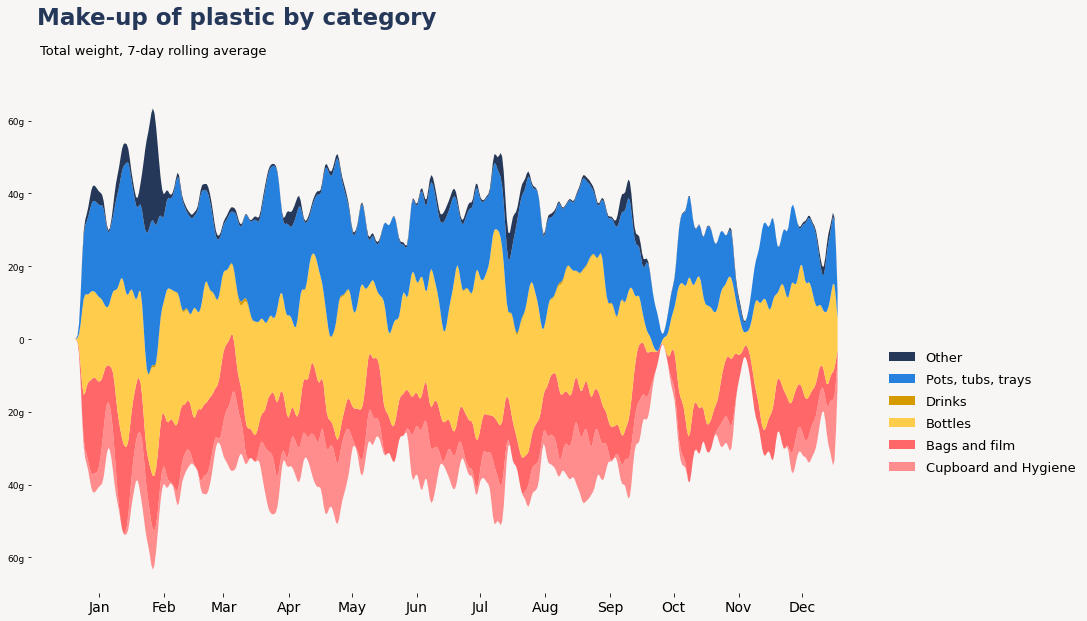

In [297]:
# =========================
# Create chart area

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)

#remove chart area frame
ax.set_frame_on(False)
#ax.set_facecolor("#f7f6f4") # change chart background colour to white

#set background colour for whole viz
fig.set_facecolor("#f7f6f4")

#remove y-axis
ax.axes.get_yaxis().set_visible(True)

# =======
#input data

#days
x = np.arange(1, 366) 

# y-values to map
columns = ['Cupboard and Hygiene','Bags and film', 'Bottles', 'Drinks','Pots, tubs, trays', 'Other'] 
y = [pivot[column].tolist() for column in columns]


# =======
# Look of streamgraph

#smooth lines 
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

#define colours
#colours = ["#ff8d8d",  "#ff6768", "#ffcd4b", "#d59a00", "#74aeea", "#2580de","#263859", "#6b778d"]

# =======
# Add title and subtitle
plt.suptitle("Make-up of plastic by category", 
             size=23, y=1.06, ha='left', x=0.03, fontweight='bold', color=cols[-1],
            fontfamily='Oswald')


plt.title("Total weight, 7-day rolling average", 
          size=13, y=1.05, ha='left', x=0.01)

# =======
# display chart


grid = np.linspace(1, 366, num=500)
#print(grid)
y_smoothed = [gaussian_smooth(x, y_, grid, 1) for y_ in y]
ax.stackplot(grid, y_smoothed, colors = cols, baseline="sym", labels=columns);

#y-axis
plt.yticks([-60, -40, -20, 0, 20, 40, 60], 
           ["60g", "40g", "20g", "0", "20g","40g", "60g"], fontsize=9)


#x-axis tickmarks
dates = ["2021-01-15", "2021-02-15",  "2021-03-15",  "2021-04-15",  "2021-05-15",  "2021-06-15",  "2021-07-15",
         "2021-08-15",  "2021-09-15",  "2021-10-15",  "2021-11-15",  "2021-12-15"]
dates = pd.DataFrame(pd.to_datetime(dates), columns=["date"])
dates["doy"] = dates["date"].dt.dayofyear
plt.xticks(dates["doy"].to_list(), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=14)

#===========
#add legend in reverse order to match chart

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [5,4,3,2,1,0]

#add legend to plot

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
            bbox_to_anchor=(1.25,0.5), frameon=False, labelspacing=0.7, fontsize=13, loc='upper right')

## Proportion Streamgraph - number of items

In [298]:
pivot = df.groupby(['date', 'category_name'])['plastic_weight'].count().unstack()

#get day of year
pivot = pivot.reset_index()
pivot["doy"] = pivot["date"].dt.dayofyear

# create empty dataframe with all day of year
pivot2 = pd.DataFrame(index=np.arange(1,366)).reset_index()

#merge both
pivot = pd.merge(pivot2, pivot, left_on='index', right_on='doy', how='left')

#remove columns
pivot = pivot.drop(columns=["doy", "date"]).rename(columns={"index": "day"})

#set index
pivot = pivot.set_index(["day"])

#7-day rolling average
pivot = pivot.fillna(0)
pivot = pivot.rolling( 7).mean().shift(0)
pivot = pivot.fillna(0)

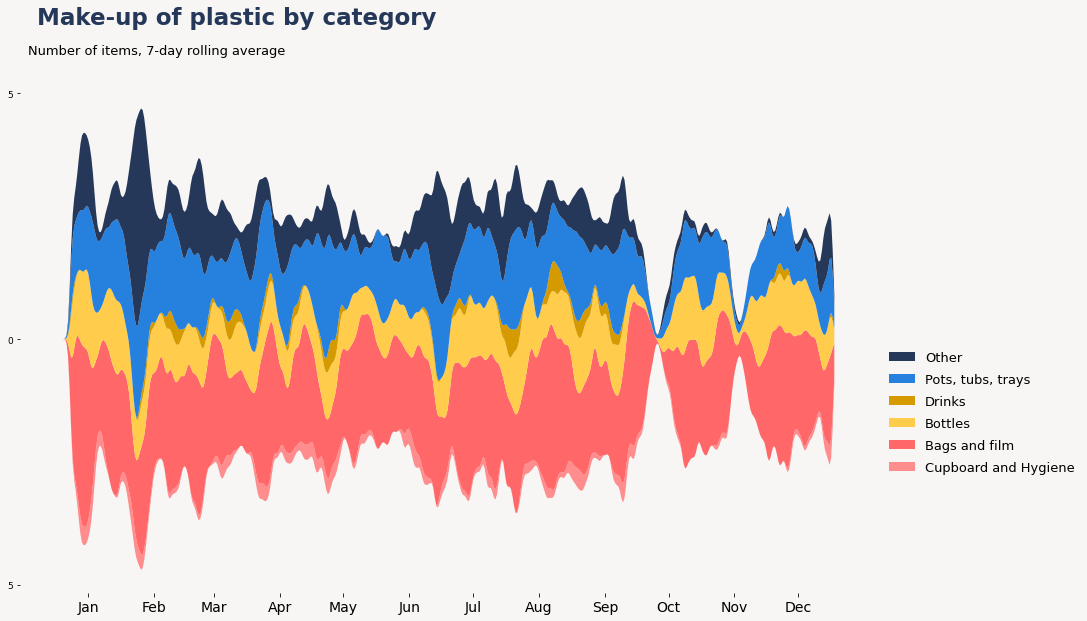

In [303]:
# =========================
# Create chart area

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)

#remove chart area frame
ax.set_frame_on(False)
#ax.set_facecolor("#f7f6f4") # change chart background colour to white

#set background colour for whole viz
fig.set_facecolor("#f7f6f4")

#remove y-axis
ax.axes.get_yaxis().set_visible(True)

# =======
#input data

#days
x = np.arange(1, 366) 

# y-values to map
columns = ['Cupboard and Hygiene','Bags and film', 'Bottles', 'Drinks','Pots, tubs, trays', 'Other'] 
y = [pivot[column].tolist() for column in columns]


# =======
# Look of streamgraph

#smooth lines 
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

#define colours
#colours = ["#ff8d8d",  "#ff6768", "#ffcd4b", "#d59a00", "#74aeea", "#2580de","#263859", "#6b778d"]

# =======
# Add title and subtitle
plt.suptitle("Make-up of plastic by category", 
             size=23, y=1.06, ha='left', x=0.03, fontweight='bold', color=cols[-1],
            fontfamily='Oswald')


plt.title("Number of items, 7-day rolling average", 
          size=13, y=1.05, ha='left', x=0.01)

# =======
# display chart


grid = np.linspace(1, 366, num=500)
#print(grid)
y_smoothed = [gaussian_smooth(x, y_, grid, 1) for y_ in y]
ax.stackplot(grid, y_smoothed, colors = cols, baseline="sym", labels=columns);

#y-axis
plt.yticks([ -5, 0, 5], 
           [ "5", "0", "5"], fontsize=9)


#x-axis tickmarks
dates = ["2021-01-15", "2021-02-15",  "2021-03-15",  "2021-04-15",  "2021-05-15",  "2021-06-15",  "2021-07-15",
         "2021-08-15",  "2021-09-15",  "2021-10-15",  "2021-11-15",  "2021-12-15"]
dates = pd.DataFrame(pd.to_datetime(dates), columns=["date"])
dates["doy"] = dates["date"].dt.dayofyear
plt.xticks(dates["doy"].to_list(), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=14)

#===========
#add legend in reverse order to match chart

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [5,4,3,2,1,0]

#add legend to plot

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
            bbox_to_anchor=(1.25,0.5), frameon=False, labelspacing=0.7, fontsize=13, loc='upper right')